In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras.layers as L
from keras.models import Model
from keras import regularizers
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [172]:
dataset=pd.read_csv('/content/sample_data/prod_task.csv', encoding='cp1252')
sentences=dataset['TASK'].to_list()

vocab_size = 5908
embedding_dim = 16
max_length = 10
trunc_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words = vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(padded[0])
print(decode_review(padded[0]))
print(sentences[0])

# reshape inputs for LSTM [samples, timesteps, features]
X_train=padded
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
print("Training data shape:", X_train.shape)
# normalize
X_train = X_train / float(vocab_size)

#Embeddings
# model_embed = tf.keras.Sequential(tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length))
# model_embed.compile(loss='mae',optimizer='adam')

def autoencoder_model(X):

    encoder = tf.keras.models.Sequential()
    encoder.add(L.InputLayer((X.shape[1], X.shape[2])))
    encoder.add(L.LSTM(16, activation='relu', return_sequences=True,kernel_regularizer=regularizers.l2(0.00)))
    encoder.add(L.LSTM(4, activation='relu', return_sequences=False))
    encoder.add(L.RepeatVector(X.shape[1]))

    decoder= tf.keras.models.Sequential()
    decoder.add(L.LSTM(4, activation='relu', return_sequences=True))
    decoder.add(L.LSTM(16, activation='relu', return_sequences=True))
    decoder.add(TimeDistributed(Dense(X.shape[2])))

    # inputs = Input(shape=(X.shape[1], X.shape[2]))
    # L1 = LSTM(16, activation='relu', return_sequences=True, 
    #           kernel_regularizer=regularizers.l2(0.00))(inputs)
    # L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    # L3 = RepeatVector(X.shape[1])(L2)
    # L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    # L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    # output = TimeDistributed(Dense(X.shape[2]))(L5)    
    # model = Model(inputs=inputs, outputs=output)

    return encoder, decoder




[  0   0   0   0  76 168 424 108 338  75]
? ? ? ? vm tools updates by esx update
VM tools updates by ESX update
Training data shape: (14416, 10, 1)


In [110]:
input_shape=X_train.shape[1:]
input_shape

(10, 1)

In [111]:
encoder,decoder = autoencoder_model(X_train)
inp = L.Input(input_shape)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = tf.keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adam", loss='mse')

history=autoencoder.fit(x=X_train, y=X_train, epochs=5, validation_split=0.05).history

# create the autoencoder model
# model.compile(optimizer='adam', loss='mae')
# model.summary()    


Epoch 1/5
428/428 [==============================] - 11s 16ms/step - loss: 0.0129 - val_loss: 0.0169
Epoch 2/5
428/428 [==============================] - 6s 15ms/step - loss: 0.0099 - val_loss: 0.0162
Epoch 3/5
428/428 [==============================] - 6s 15ms/step - loss: 0.0092 - val_loss: 0.0155
Epoch 4/5
428/428 [==============================] - 6s 15ms/step - loss: 0.0087 - val_loss: 0.0147
Epoch 5/5
428/428 [==============================] - 6s 15ms/step - loss: 0.0083 - val_loss: 0.0138


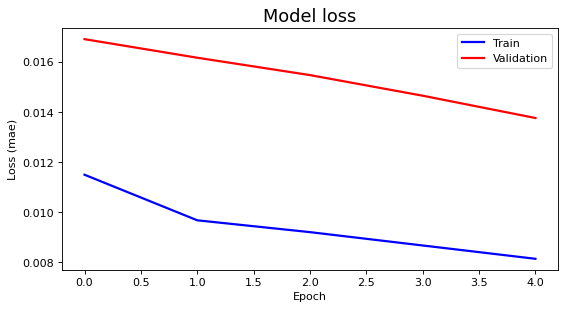

In [112]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

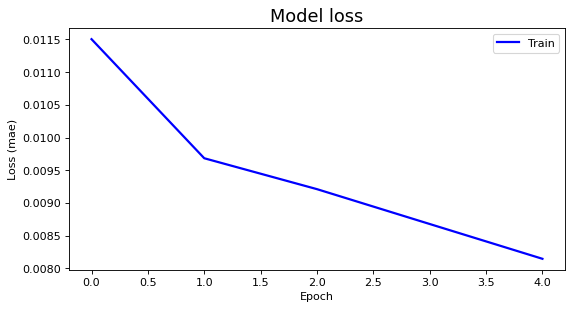

In [113]:
# # fit the model to the data
# nb_epochs = 10
# batch_size = 32
# history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size).history

# plot the training losses
fig, ax = plt.subplots(figsize=(8, 4), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
# ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()



In [115]:
####Test data

test_data=pd.read_csv('/content/sample_data/cumminstrainingdata.csv')
test_data=test_data['description'].to_list()

sentences=test_data
tokenizer = Tokenizer(num_words = vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(sentences)
test_padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)
# reshape inputs for LSTM [samples, timesteps, features]
X_test=test_padded
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
print("Test data shape:", X_test.shape)

Test data shape: (6624, 10, 1)


In [173]:
X_train.shape

(14416, 10, 1)

In [174]:
#Save encodings
codes = encoder.predict(X_train) 
nsamples, nx, ny = codes.shape
codes = codes.reshape((nsamples,nx*ny))

In [197]:
from sklearn.neighbors import NearestNeighbors
nei_clf = NearestNeighbors(p=2,metric='cosine')
nei_clf.fit(codes)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [218]:
test_sentences=['Hi hello how are you !']
# tokenizer = Tokenizer(num_words = vocab_size, oov_token="<OOV>")
# tokenizer.fit_on_texts(sentences)
# word_index = tokenizer.word_index
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, maxlen=max_length, truncating=trunc_type)
X_test=test_padded
X_test=test_padded.reshape(1,test_padded.shape[1],1)
X_test.shape

(1, 10, 1)

In [219]:
# code = encoder.predict(X_test[2000].reshape(1,X_test.shape[1],1))
code = encoder.predict(X_test)
nsamples, nx, ny = code.shape
code = code.reshape((nsamples,nx*ny))


In [220]:
distances,indices = nei_clf.kneighbors(code,n_neighbors=1)
distances,indices

(array([[5.364418e-07]], dtype=float32), array([[13473]]))

In [200]:
X_inp=padded
X_inp.shape=X_train.shape[:2]
X_inp.shape

(14416, 10)

In [222]:
decode_review(test_padded[0])

'? ? ? ? ? hi <OOV> how are you'

In [223]:
decode_review(X_inp[13473])

'? ? sunrise report tools partially report of one track'